# OpenHAP chamber test

## Import required libraries

In [7]:
import csv
import time
import datetime
import paho.mqtt.client as mqtt

## Setup defaults

In [14]:
broker_address = "127.0.0.1"

time_field_txt = "Time"
device_field_txt = 'Device'
measurement_field_txt = 'measurement'
csv_fieldnames = [time_field_txt, device_field_txt, measurement_field_txt]

csv_file = "chamberTest.csv"

## Set dynamic plotting function

In [48]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(x, y, figsize=(20,10), title='Particulate measurement against time'):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.grid(True)
    plt.ylabel('Particulate concentration')
    plt.xlabel('Datetime')
    plt.plot_date(x, y, 'o')
    clear_output(wait=True)
    plt.show();

## Setup event callbacks

In [44]:
import numpy as np
import pandas as pd

command_mid = 0
measurement_mid = 0
system_mid = 0 

def on_connect(client, userdata, flags, rc):
    if rc == 0:
        print("Connected OK Returned code=",rc)
        system_mid = client.subscribe("$SYS/broker/clients/#")[-1]
        command_mid = client.subscribe("command")[-1]
        measurement_mid = client.subscribe("measurement/#")[-1]
    
def on_subscribe(client, userdata, mid, granted_qos):       
    if mid == measurement_mid:
        print("measurement topics successfully subscribed")
    elif mid == command_mid:
        print("Command topic successfully subscribed")
    elif mid == system_mid:
        print("System topic successfully subscribed")
    else:
        print("Other topic subscription acknowledgement received")

def on_message(client, userdata, message):
    if message.topic == "command":
        print("Measurement command sent!")
    if "measurement" in message.topic:
            mqtt_topic_levels = message.topic.split('/')
            if len(mqtt_topic_levels) != 2:
                print("Improperly formatted measurement topic received")
            else:
                measurement_time = datetime.datetime.now()
                device = mqtt_topic_levels[1]
                value = int(message.payload)
                
                print("Measurement received: "
                     f"Device {device} "
                     f"at {measurement_time} "
                     f"value {value}\n")
                
                with open(csv_file, 'a') as measurement_file:
                    print("CSV file opened - writing header")
                    writer = csv.DictWriter(measurement_file, fieldnames=csv_fieldnames)
                    writer.writerow({time_field_txt: measurement_time,
                                     device_field_txt: device,
                                     measurement_field_txt:value})
                    measurement_file.close()
                df = pd.read_csv(csv_file)
                df[time_field_txt].to_numpy()
                live_plot(df[time_field_txt].to_numpy(), df[measurement_field_txt].to_numpy())

## Test code

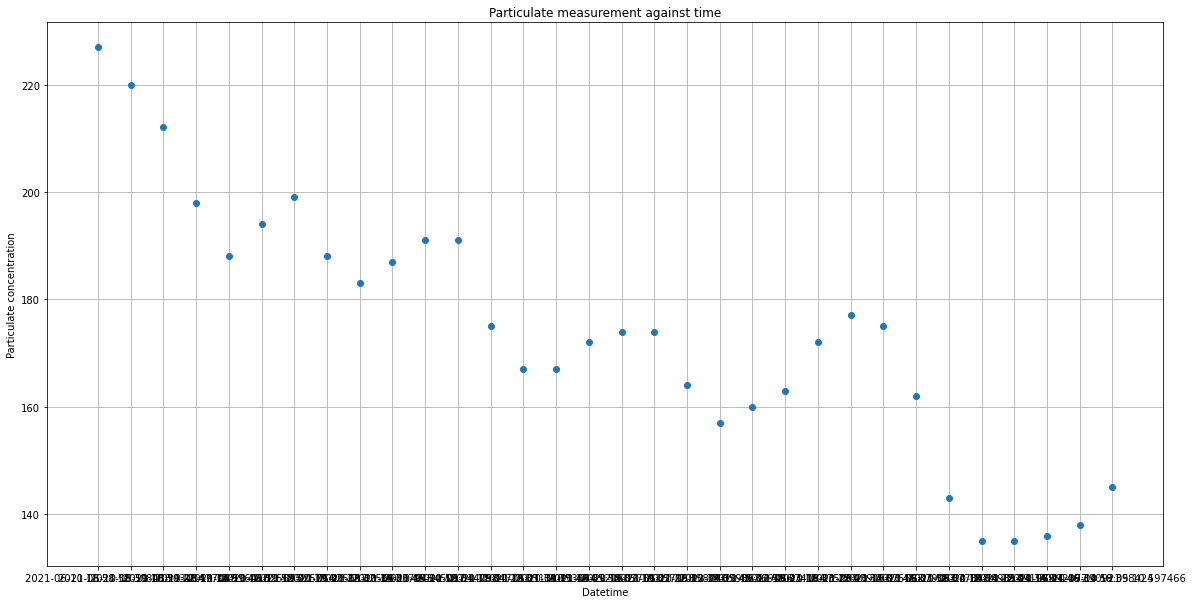

CSV file closed and event loop thread stopped
End of program


In [49]:
controller = mqtt.Client("controller",clean_session=True)

controller.on_connect = on_connect
controller.on_subscribe = on_subscribe
controller.on_message = on_message

#Open CSV file for writing in overwrite mode
with open(csv_file, 'w') as measurement_file:
    print("CSV file opened - writing header")
    writer = csv.DictWriter(measurement_file, fieldnames=csv_fieldnames)
    writer.writeheader()
    measurement_file.close()
    
controller.connect(broker_address)
controller.loop_start()

while True:
    try:
        controller.publish("command", "measure")
        time.sleep(12)
    except KeyboardInterrupt:
        controller.loop_stop()
        controller.disconnect()
        print("CSV file closed and event loop thread stopped")
        break
print("End of program")